In [1]:
# !pip install ultralytics

In [2]:
# !pip install squarify

In [1]:
# import libraries
from ultralytics import YOLO
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

import squarify
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import random
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

# import warnings
%matplotlib inline


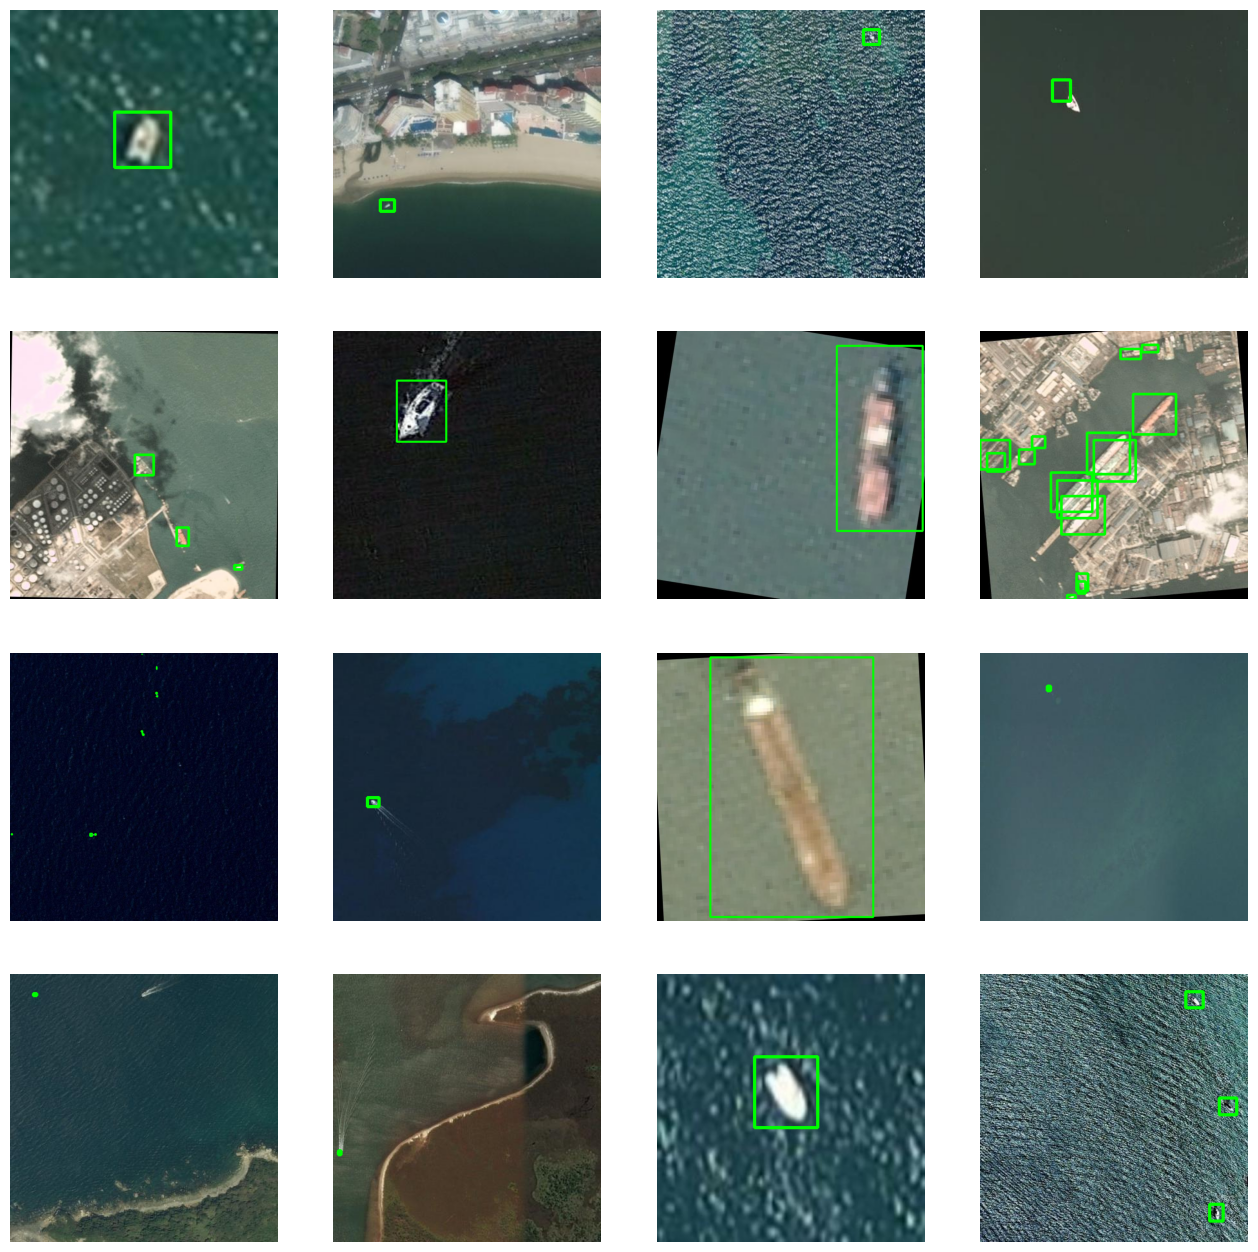

In [2]:
train_images = r"D:\yoloTest\Ship_Detection\ships-aerial-images\train\images"
val_images = r"D:\yoloTest\Ship_Detection\ships-aerial-images\valid\images"
test_images = r"D:\yoloTest\Ship_Detection\ships-aerial-images\test\images"

train_labels = r"D:\yoloTest\Ship_Detection\ships-aerial-images\train\labels"
val_labels = r"D:\yoloTest\Ship_Detection\ships-aerial-images\valid\labels"
test_labels = r"D:\yoloTest\Ship_Detection\ships-aerial-images\test\labels"

# Mendapatkan list keseluruhan gambar kapal
image_files = os.listdir(train_images)

# Pilih secara acak 16 gambar
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

## `Training Model`

In [3]:
dataset = r"ships-aerial-images\data.yaml"

In [4]:
model_nano = YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     


  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256,

In [6]:
model_nano.train(data=dataset,
            epochs=100,
            patience=50,
            imgsz=256,
            batch=64,
            save=True,
            workers=0,
            optimizer='auto',
            project='Ship Detection',
            name='Second_Training_Nanopt',
            cache=True,
            device=0,
            exist_ok=True,
            resume=True)

New https://pypi.org/project/ultralytics/8.0.155 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=ships-aerial-images\data.yaml, epochs=100, patience=50, batch=64, imgsz=256, save=True, save_period=-1, cache=True, device=0, workers=0, project=Ship Detection, name=Second_Training_Nanopt, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False

## `Hyperparameter Opt`

In [15]:
# dataset baru

dataset_baru = './ships-aerial-images/data.yaml'
model= YOLO("./Second_Training_Nanopt/weights/best.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'Second_Training_Nanopt\\weights\\best.pt'

In [17]:
result_grid = model.tune(data=dataset_baru,
                         epochs=100)

2023-08-16 12:03:04,083	INFO wandb.py:305 -- Already logged into W&B.
2023-08-16 12:03:06,097	WARNING worker.py:2033 -- Warning: The actor ImplicitFunc is very large (24 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-08-16 12:03:09,851	ERROR tune_controller.py:911 -- Trial task failed for trial _tune_2e4da_00002
Traceback (most recent call last):
  File "c:\Users\dika_atma\anaconda3\envs\yolov8\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\dika_atma\anaconda3\envs\yolov8\lib\site-packages\ray\_private\auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\dika_atma\anaconda3\envs\yolov8\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\dika_atma\anaconda3\env